In [ ]:
!pip install pandahouse

In [ ]:
!pip install swifter

In [3]:
import pandas as pd
import pandahouse
import swifter
import hashlib
import seaborn as sns
from scipy import stats
import numpy as np
from random import sample
import numpy as np
from scipy.stats import ttest_ind

#Задание 1

In [4]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230720'
}

#Задание 2

Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2023-06-30 по 2023-07-06 включительно. Для эксперимента были задействованы 2 и 1 группы.

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля.

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR.

Ваша задача — проанализировать данные АB-теста.

Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).

Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как сработали?


Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.

Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

* exp_group = 1 - Все по-старому
* exp_group = 2 - Новый алгоритм

In [5]:
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2023-06-30' and '2023-07-06'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""
# Вытащили пользователей
df = pandahouse.read_clickhouse(q, connection=connection)

In [6]:
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,18392,7,32,0.218750
4,1,26295,39,141,0.276596


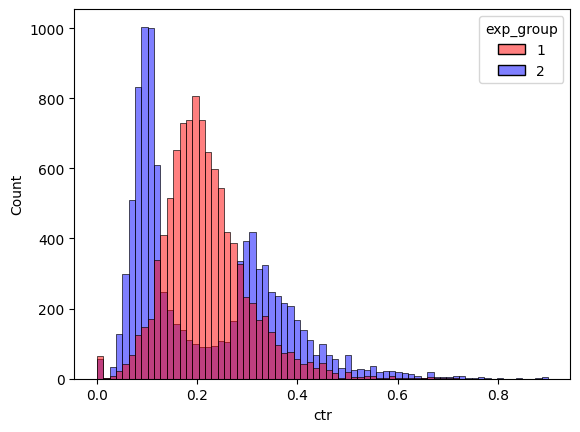

In [ ]:
groups = sns.histplot(data = df,
              x='ctr',
              hue='exp_group',
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

из графика видно что в двух группах много разных значений можно использовать тест мана-витни и проверим т-тест

In [8]:
#T-тест
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

Статистика теста (statistic):
Значение статистики t (в данном случае 0.405) показывает, как сильно различаются средние значения между двумя группами. В данном контексте, значение статистики близко к нулю, что указывает на то, что средние значения CTR (отношение кликов к просмотрам) в группах 1 и 2 не сильно различаются друг от друга.

P-value (pvalue):
Значение p-value (в данном случае 0.685) является вероятностью получить такие же или более экстремальные различия между группами, какие были наблюдены в эксперименте, при условии, что нулевая гипотеза верна. Нулевая гипотеза в данном случае гласит, что нет статистически значимого различия между средними значениями CTR в двух группах (новый алгоритм не влияет на CTR). Чем выше p-value, тем более вероятно, что нулевая гипотеза верна.

Интерпретация:

Если p-value > 0.05 (уровень значимости), то результаты теста не дают оснований отвергнуть нулевую гипотезу. В данном случае p-value равно 0.685, что гораздо больше 0.05, следовательно, результаты теста не дают оснований считать различия между группами статистически значимыми.
Следовательно, на основе данных этого t-теста нет статистических доказательств, что новый алгоритм рекомендации постов в группе 2 привел к увеличению CTR по сравнению с группой 1.

In [9]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

Таким образом, на основе результатов теста Манна-Уитни, можно сделать вывод, что новый алгоритм рекомендации постов во 2-й группе привел к статистически значимому уменьшению CTR по сравнению с группой 1 (контрольной группой). Это отрицательный результат,


Рассмотрите другие методы:

Если у вас есть перекос в данных и много выбросов, тесты на сглаженном CTR, бутстреп или бакетное преобразование могут быть более устойчивыми к таким выбросам и дадут более надежные результаты.

Для более детального анализа возьмем бакетное преобразование с Манна-Уитни, т.к у нас есть не равномерное распределение ctr во 2 группе, а  бакетное преобразование позволит нам сгладить этот момент. Посмотрим верно ли гипотеза

In [10]:
q = """
SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group,
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions
    WHERE toDate(time) between '2023-06-30' and '2023-07-06'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = pandahouse.read_clickhouse(q, connection=connection)

#тест Манна-Уитни видит отличие
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr,
                   df[df.exp_group == 2].bucket_ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

<Axes: xlabel='bucket_ctr', ylabel='Count'>

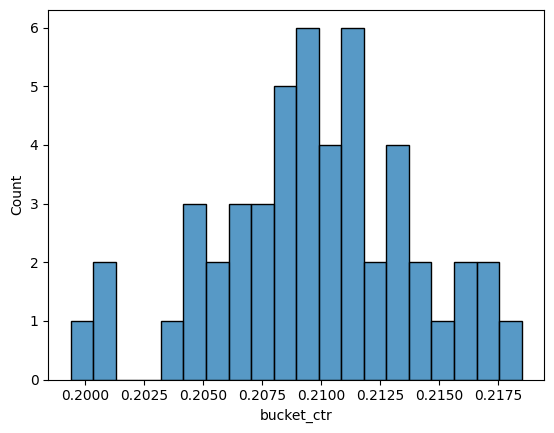

In [11]:
sns.histplot(df[df.exp_group == 1].bucket_ctr, bins=20)

Распределение не слишком перекошено, нормально

<Axes: xlabel='ctr9', ylabel='Count'>

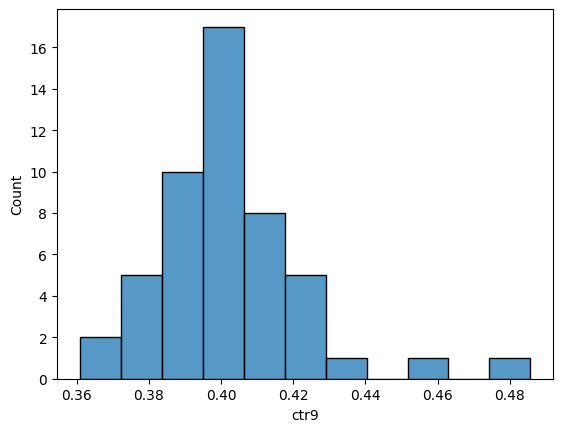

In [12]:
sns.histplot(df[df.exp_group == 2].ctr9)

In [13]:
#тест Манна-Уитни видит отличие
stats.mannwhitneyu(df[df.exp_group == 1].ctr9,
                   df[df.exp_group == 2].ctr9,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=0.0, pvalue=6.7601631082665925e-18)

По предоставленным результатам теста Манна-Уитни, видно, что тест обнаружил статистически значимое отличие между значениями CTR9 (90-й перцентиль CTR) в двух группах (группа 1 и группа 2). Значение p-value равно 6.7601631082665925e-18, что гораздо меньше уровня значимости 0.05. Это говорит о том, что различие между значениями CTR9 в двух группах является статистически значимым.

Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.

- новый алгоритм не учитывает потребности всех пользователей мы видим, что во 2 группе есть две крайности, можно предположить, что в группе есть разногласия и, например были выбраны пользователи не одинаковой возрастной группы, пола и т.д.
- может быть алгоритм выдавал рандомные посты и рекомендации, которые крайне неэффективны  

Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.
- Я не рекомендую раскатывать новый алгоритм на всех пользователей. Тест нужно доработать есть много выбросов/нестабильных значений

